# Calibration of the HBV model

In this chapter the HBV model is calibrated using the observation data. A set of parameters is used by the HBV model to model the discharge. These parameters are calibrated to make the model work for the catchment area of the Wien River. 

## Model Selection

To be able to model the expected future discharge, the Hydrologiska Byråns Vattenbalansavdelning (HBV) model is chosen. The developer of the model, Sten Bergström (1992), says the HBV model can best be classified as a semi-distributed conceptual model. The model represents a catchment area by using interconnected storage reservoirs to simulate the movement of water. By adjusting nine parameters, the HBV model can be calibrated to different catchment areas. A visual representation of the HBV model can be seen in the figure below.

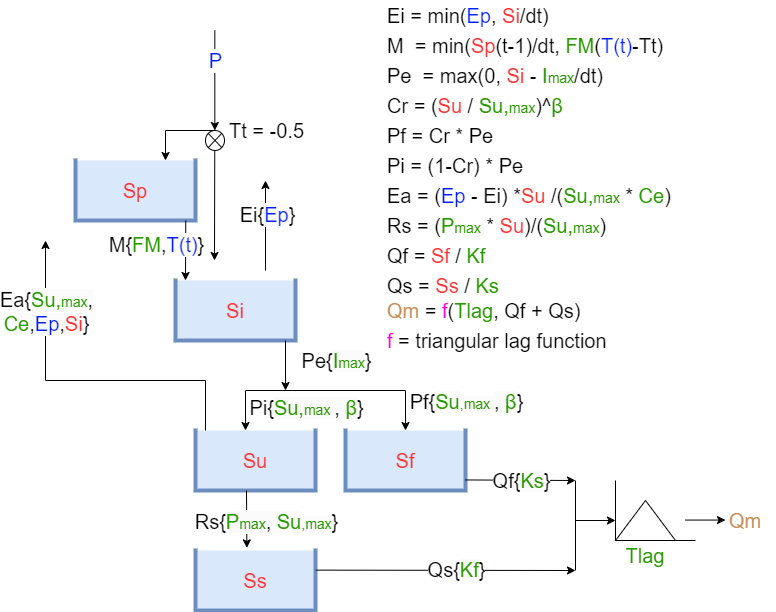

Figure 5: Layout HBV Model (Hrachowitz, M)

In [48]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

#niceties
from rich import print
import seaborn as sns
sns.set()

# #needed
# from ipywidgets import IntProgress
# from IPython.display import display

# general eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

As stated in chapter 3, eWaterCycle provides access to the Caravan dataset, from which a Camel dataset of the catchment of the Wien River is loaded.

In [4]:
camelsgb_id = "lamah_208082"

  The start and end date of the experiment have to be specified. The start and end date of the calibration have to be specified as well. The period of calibration is chosen to be around 75% of the experiment period. This means that the model is trained on 75% of the observation data, and can be tested on 25% of the observation data, to make sure the model is not only working for the data it was trained on, but on other periods of data as well. 

In [5]:
# calibration dates op 75% van de experiment dates zetten!!!

experiment_start_date = "1981-08-01T00:00:00Z"
experiment_end_date = "2018-01-01T00:00:00Z"

calibration_start_time = experiment_start_date
calibration_end_time = "2007-08-31T00:00:00Z"

validation_start_time = "2007-09-01T00:00:00Z" 
validation_end_time = experiment_end_date

The forcing data can be generated or previously generated data can be loaded.

In [6]:
# Even though we don't use caravan data as forcing, we still call it forcing
# because it is generated using the forcing module of eWaterCycle
forcing_path_caravan = Path.home() / "forcing" / camelsgb_id / "caravan"
forcing_path_caravan.mkdir(exist_ok=True, parents=True)

# If someone has prepared forcing for you, this path needs to be changed to that location. 
prepared_forcing_path_caravan_central = Path("location/of/forcing/data")

In [7]:
# # option one: generate forcing data
# camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].generate(
#     start_time=experiment_start_date,
#     end_time=experiment_end_date,
#     directory=forcing_path_caravan,
#     basin_id=camelsgb_id,
# )


# option two or three: load data that you or someone else generated previously
camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].load(Path("/home/thirza/forcing/lamah_208082/caravan"))

print(camelsgb_forcing)

CaravanForcing(
    start_time='1981-08-01T00:00:00Z',
    end_time='2030-12-31T00:00:00Z',
    directory=PosixPath('/home/thirza/forcing/lamah_208082/caravan'),
    shape=PosixPath('/home/thirza/forcing/lamah_208082/caravan/lamah_208082.shp'),
    filenames={
        'tasmax': 'lamah_208082_1981-08-01_2030-12-31_tasmax.nc',
        'tas': 'lamah_208082_1981-08-01_2030-12-31_tas.nc',
        'tasmin': 'lamah_208082_1981-08-01_2030-12-31_tasmin.nc',
        'Q': 'lamah_208082_1981-08-01_2030-12-31_Q.nc',
        'pr': 'lamah_208082_1981-08-01_2030-12-31_pr.nc',
        'evspsblpot': 'lamah_208082_1981-08-01_2030-12-31_evspsblpot.nc'
    }
)

Above, it can be seen that the forcing data contains precipitation, potential evaporation, discharge and the near-surface temperatures (tas). For this research, only the discharge data is relevant. The discharge data is loaded from the forcing below, and is plotted.

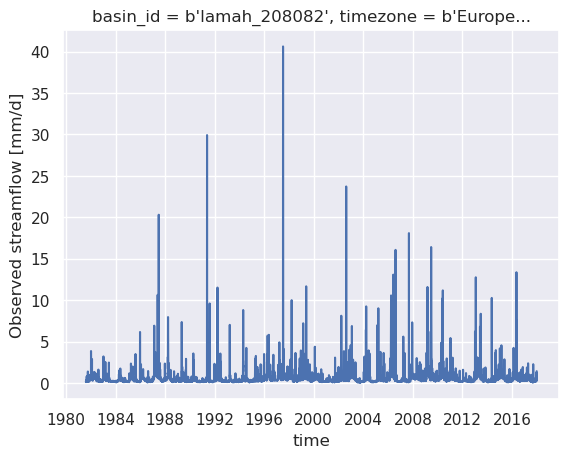

In [37]:
#quick plot of the discharge data.
ds_forcing = xr.open_mfdataset([camelsgb_forcing['Q'], camelsgb_forcing['pr'], camelsgb_forcing['evspsblpot']])
ds_forcing["Q"].plot()

## Calibration

The HBV model contains five stores where the water is stored and nine parameters that control the flow between those stores and in and out of the model. For the storages an array of starting values is specified. The values for the parameters will later be estimated using optimization.

In [7]:

#               Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5, 0])
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Slowflow storage", "Groundwater storage"]

p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
param_names = ["Imax","Ce",  "Sumax", "beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]\

# p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001,  .01])
# p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01,  0.5])

# p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   0.1,  .01,  .0001,  .01])
# p_max_initial = np.array([8,    4,  800,   4,    3,     10,    3,   .1,  5])


##### The following part tries to find the best parameter combination using a randomizer. Later I used better ways so I commented this part because I don't think I will use it.

### Randomizer

To be able to find a good combination of parameters, a randomizer is used. It creates N possible combinations of parameters, with each of these parameters having a value in between the initial minimum and maximum values.

In [8]:
# N = 100

# parameters = np.random.uniform(p_min_initial[:, np.newaxis], p_max_initial[:, np.newaxis], (len(p_min_initial), N))
# # print(parameters)

The next step is to run the HBV model with the forcing, the randomly chosen parameters and the initally set storage data. First of all an empty list is made, called 'ensemble'. The HBV model is run N times, with every time another set of the randomly chosen parameters from above. The outcomes of the HBV model are stored in the ensemble list.

In [9]:
# ensemble = []
# for counter in range(N): 
#     ensemble.append(ewatercycle.models.HBVLocal(forcing=camelsgb_forcing))
#     config_file, _ = ensemble[counter].setup(
#                             parameters = parameters[:,counter],
#                             initial_storage=s_0,
#                             cfg_dir = "configFiles/hbv_ensembleMember_" + str(counter),
#                                )
#     ensemble[counter].initialize(config_file)

To be able to determine if the outcomes of the HBV model are any good, the results can be compared to the observations. It is important to first determine when the model works good. This research focusses on the flooding threshold of the U4 subway line. Flooding happens at high discharges, peaks. This implies that the model can be seen as good, when the amount and height of the modelles peaks are similar to the peaks in the observed data. This is done with the following function. The difference between the modelled data and the observed data is raised to the second power, to 'punish' large absolute differences more heavy. The absolute difference between the observed data and the modelled data is higher at the peaks. In this way the parameter combination is looked for which results in the 'best' model, defined above. 

In [10]:
# def calibrationObjective(modelOutput, observation, start_calibration, end_calibration):
#     # a function that takes in two dataFrames, interpolates the model output to the
#     # observations and calculates the average absolute difference between the two.

#     #combine the two in one dataFrame
#     hydro_data = pd.concat([modelOutput.reindex(observation.index, method = 'ffill'), observation], axis=1)

#     #only select the calibration period
#     hydro_data = hydro_data[hydro_data.index > pd.to_datetime(pd.Timestamp(start_calibration).date())]
#     hydro_data = hydro_data[hydro_data.index < pd.to_datetime(pd.Timestamp(end_calibration).date())]

#     #calculate mean absolute difference to the power 4, so peaks weigh more
#     diff = (hydro_data['Q'] - hydro_data['model output']) ** 2
#     absDiff = np.abs(diff)
#     meanAbsDiff = np.mean(absDiff)

#     return meanAbsDiff

Now the differences between the model and the observed data can actually be calculated. Every ensemble is compared to the observed data. The mean absolute differences between the modelled discharges and the observed discharges are called objectives. 

In [11]:
# #an object to show a progress bar, since this can take a while:
# f = IntProgress(min=0, max=N) # instantiate the bar
# display(f) # display the bar

# #converting the observations to a pandas object
# Q_pandas = ds_forcing["Q"].to_dataframe()
# #an empty array to store the results in
# objectives = []

# #loop over all ensemble members
# for ensembleMember in ensemble:
#     Q_m = []
#     time = []
#     while ensembleMember.time < ensembleMember.end_time:
#         ensembleMember.update()
#         discharge_this_timestep = ensembleMember.get_value("Q")
#         Q_m.append(discharge_this_timestep[0])
#         time.append(pd.Timestamp(ensembleMember.time_as_datetime.date()))

#     #calculate the objective function 
#     discharge_dataframe = pd.DataFrame({'model output': Q_m}, index=pd.to_datetime(time))
#     objective_this_model = calibrationObjective(discharge_dataframe,Q_pandas["Q"],calibration_start_time,calibration_end_time)
#     objectives.append(objective_this_model)

#     #it is good practice to remove any variable you don't need anymore to save memory.
#     del Q_m, time, discharge_dataframe, objective_this_model
   
#     #update progress bar
#     f.value += 1

# # print(objectives)  

In [12]:
# #let's also show the minimal values:
# parameters_minimum_index = np.argmin(np.array(objectives))

# objective_minimum = np.min(objectives)

# parameters_minimum = parameters[:,parameters_minimum_index]

# print("Best parameter index:", parameters_minimum_index)
# print("Best parameter set:", parameters_minimum)
# print("Objective: ", objective_minimum)


In [13]:
# #finaly, just like before, we remove the models themselves to save up space and memory.
# for ensembleMember in ensemble:
#     ensembleMember.finalize()

Now the results can be analyzed. The parameter set that results in the lowest objective value, is the best found parameter combination to calibrate the model to the observations.  

In [14]:
import matplotlib.pyplot as plt

In [15]:
# xFigNr = 2
# yFigNr = 4

# fig, axs = plt.subplots(xFigNr, yFigNr,figsize = (15,15))

# for xFig in range(xFigNr):
#     for yFig in range(yFigNr):
#         paramCounter = xFig*yFigNr + yFig
#         axs[xFig,yFig].plot(parameters[paramCounter,:],objectives,'.')
#         axs[xFig,yFig].set_title(p_names[paramCounter])

We can compare the modelled discharge to the observed discharge by plotting both. First a model object needs to be created. Following, a configuration file is created that cotains information on the location of the forcing files and the values of the inital storages and the parameters. Then the model gets primed to start running through initializing.

In [16]:
# par_0 = parameters_minimum
# model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
# config_file, _ = model.setup(parameters=par_0, initial_storage=s_0)
# model.initialize(config_file)

Now the model can start running.

In [17]:
# Q_m = []
# time = []
# while model.time < model.end_time:
#     model.update()
#     Q_m.append(model.get_value("Q")[0])
#     time.append(pd.Timestamp(model.time_as_datetime))
# model.finalize()

In [18]:
# model_output = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

The modelled discharge and the observed discharge can be plotted to determine the accuracy of the model.

In [19]:
# ds_forcing["Q"].plot(label="Observed discharge")
# model_output.plot()
# plt.legend()
# plt.ylabel("Discharge (mm/d)")

To be able to use the output of the model in other analyses, it is saved as a NetCDF file:

In [20]:
# xr_model_output = model_output.to_xarray()

# xr_model_output.attrs['units'] = 'mm/d'

# # Save the xarray Dataset to a NetCDF file
# xr_model_output.to_netcdf('~/river_discharge_data.nc')

### Quantile Loss method and optimization with Nelder-Mead

Another way of weighing the peaks more heavily is using the quantile loss method. The quantile loss method measures how well the model predicts a specific quantile by penalizing over- and under predictions more heavily. A quantile of more than 50 percent, weighs under predictions more heavily, and thus focusses more on the peaks.

Before, the parameter combinations were chosen randomly. A better way to predict the best parameter combination is through Nelder-Mead optimization. This optimization method finds the minimum of a function. The result of the Nelder-Mead optimization is the best parameter com
bination the method found. The Nelder-Mead optimization is run using the quantile loss method with quantiles of 90, 95 and 99 percent. All three the quantiles were used for now to see how they would result. 

In [21]:
ensemble = []

In [22]:
def calibrationObjective_quantile_loss(modelOutput, observation, start_calibration, end_calibration, q):
    # a function that takes in two dataFrames, interpolates the model output to the
    # observations and calculates the average absolute difference between the two.

    #combine the two in one dataFrame
    hydro_data = pd.concat([modelOutput.reindex(observation.index, method = 'ffill'), observation], axis=1)

    #only select the calibration period
    hydro_data = hydro_data[hydro_data.index > pd.to_datetime(pd.Timestamp(start_calibration).date())]
    hydro_data = hydro_data[hydro_data.index < pd.to_datetime(pd.Timestamp(end_calibration).date())]

    #calculate mean absolute difference to the power 4, so peaks weigh more
    diff = (hydro_data['Q'] - hydro_data['model output']) 
    absDiff = np.abs(diff)
    meanAbsDiff = np.mean(absDiff)
    
    return np.mean(np.maximum(q * diff, (q - 1) * diff))  # Quantile loss formule
    

    #return meanAbsDiff

In [23]:
# ensemble.append(ewatercycle.models.HBVLocal(forcing=camelsgb_forcing))
# config_file, _ = ensemble[counter].setup(
#                             parameters = parameters[:,counter],
#                             initial_storage=s_0,
#                             cfg_dir = "configFiles/hbv_ensembleMember_" + str(counter),
#                                )
# ensemble[counter].initialize(config_file)

In [24]:
Q_pandas = ds_forcing["Q"].to_dataframe()
def objective_function(parameter_vector, q):
    model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
    config_file, _ = model.setup(            parameters = parameter_vector,
                            initial_storage=s_0,
                            cfg_dir = "configFiles/hbv_ensembleMember_",
                               )
    model.initialize(config_file)


   # discharge_this_timestep = model.get_value("Q") 
    Q_m = []
    time = []
    while model.time < model.end_time:
        model.update()
        discharge_this_timestep = model.get_value("Q")
        Q_m.append(discharge_this_timestep[0])
        time.append(pd.Timestamp(model.time_as_datetime.date()))
   # model.finalize()
   # print(model.get_value("Q"))

    #calculate the objective function 
    discharge_dataframe = pd.DataFrame({'model output': Q_m}, index=pd.to_datetime(time))

    objective_this_model = calibrationObjective_quantile_loss(discharge_dataframe,Q_pandas["Q"],calibration_start_time,calibration_end_time, q)
    del Q_m, time, discharge_dataframe
   
    if np.isnan(objective_this_model):
        return np.inf
    
    return objective_this_model

In [25]:
# objective_function(parameters_minimum)

In [26]:
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001,  .01])
p_max_initial = np.array([50,    1,  800,   40,    3,     10,    1,   .1,  0.9])

The next cell is commented because the cell takes very long to run, so I did not want to run it accidentally. I hardcoded the outcomes of the cell in the cells below.

In [27]:
from scipy.optimize import minimize


# #bounds = [(0, 500), (0.2, 10),(40, 10000),(0.5, 10000),(0.001, 300),(1, 100),(0.01, 100),(0.0001, 10),(0.01, 100)]
bounds = [(0, None), (0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None)]

# # result = minimize(objective_function, [2.10831791e+01, 2.85049614e-01, 2.05644822e+03, 2.62675362e+01,
# #  2.90142667e+02, 1.37651503e+00, 2.39202301e+00, 1.26140676e+00,
# #  2.99032767e-01], bounds=bounds, method='Nelder-Mead', options={'xatol' : 0.000001})

# result90 = minimize(objective_function, [2.52268517e-05, 2.20175052e+00, 1.45074493e+02, 2.48038674e+00,
#        1.01841470e+00, 6.84361550e-01, 5.85949449e-01, 4.42305303e-02,
#        1.05644244e+00], bounds=bounds, method='Nelder-Mead', options={'maxiter':3000}, args=(0.9,))

# result95 = minimize(objective_function, [2.52268517e-05, 2.20175052e+00, 1.45074493e+02, 2.48038674e+00,
#        1.01841470e+00, 6.84361550e-01, 5.85949449e-01, 4.42305303e-02,
#        1.05644244e+00], bounds=bounds, method='Nelder-Mead', options={'maxiter':3000}, args=(0.95,))


# result99 = minimize(objective_function, [2.52268517e-05, 2.20175052e+00, 1.45074493e+02, 2.48038674e+00,
#        1.01841470e+00, 6.84361550e-01, 5.85949449e-01, 4.42305303e-02,
#        1.05644244e+00], bounds=bounds, method='Nelder-Mead', options={'maxiter':3000}, args=(0.99,))

# result97 = minimize(objective_function, [2.52268517e-05, 2.20175052e+00, 1.45074493e+02, 2.48038674e+00,
#        1.01841470e+00, 6.84361550e-01, 5.85949449e-01, 4.42305303e-02,
#        1.05644244e+00], bounds=bounds, method='Nelder-Mead', options={'maxiter':3000}, args=(0.97,))

In [28]:
# result90

In [29]:
# result95

In [30]:
# result97

In [31]:
# result99

In [32]:
# print(result90.fun)
objective90 = 0.11857370061371166
# print(result95.fun)
objective95 = 0.08865588020728175
# print(result99.fun)
objective99 = 0.04227177059570846
# 0.9847863938751269  L-BFGS-B   kwadraat
#    0.78874967095675                 Nelder-Mead  kwadraat

#1.4835419784065083  random met **4

# print(result97.fun)

In [33]:
# result90.x 
# print(result90.x)
result90 = [5.58471586e-06, 3.13412625e+00, 2.37953048e+02, 5.73162134e+00,
 6.52902354e-01, 1.45007782e+00, 5.04868854e-01, 4.09678016e-02,
 1.08868030e+00]

# result95.x
# print(result95.x)
result95 = [1.11445722e-08, 2.44479717e+00, 4.25370410e+01, 1.22686880e+00,
 2.09277774e+00, 1.04205225e+00, 7.27472601e-01, 3.49031666e-02,
 1.08389293e+00]

# result99.x
# print(result99.x)
result99 = [1.04288193e-05, 7.77284772e+01, 2.32176569e+01, 6.60999969e-01,
 3.51075714e+00, 9.61766614e-01, 8.11764125e-01, 3.70046705e-02,
 1.00978819e+00]


# print(result97.x)

In [34]:
par_90 = result90
model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
config_file, _ = model.setup(parameters=par_90, initial_storage=s_0)
model.initialize(config_file)

In [35]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))
model.finalize()

In [36]:
model_output90 = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

Text(0.5, 1.0, 'Modelled and Observed discharge with q=0.90')

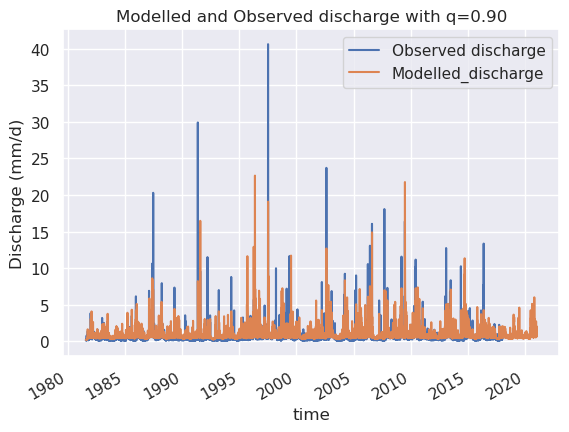

In [37]:
ds_forcing["Q"].plot(label="Observed discharge")
model_output90.plot()
plt.legend()
plt.ylabel("Discharge (mm/d)")
plt.title('Modelled and Observed discharge with q=0.90')

In [38]:
par_95 = result95
model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
config_file, _ = model.setup(parameters=par_95, initial_storage=s_0)
model.initialize(config_file)

In [39]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))
model.finalize()

In [40]:
model_output95 = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

Text(0.5, 1.0, 'Modelled and Observed discharge with q=0.95')

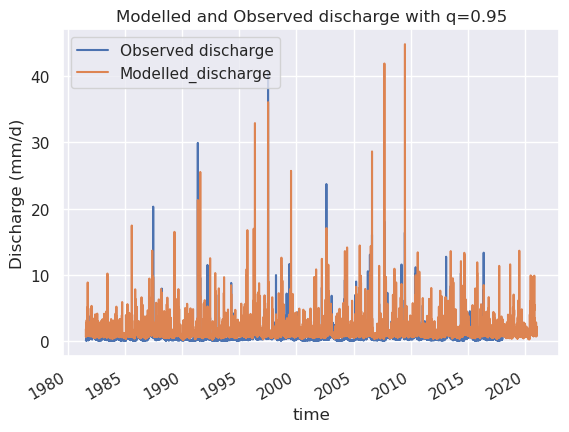

In [41]:
ds_forcing["Q"].plot(label="Observed discharge")
model_output95.plot()
plt.legend()
plt.ylabel("Discharge (mm/d)")
plt.title('Modelled and Observed discharge with q=0.95')

In [42]:
par_99 = result99
model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
config_file, _ = model.setup(parameters=par_99, initial_storage=s_0)
model.initialize(config_file)

In [43]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))
model.finalize()

In [44]:
model_output99 = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

Text(0.5, 1.0, 'Modelled and Observed discharge with q=0.99')

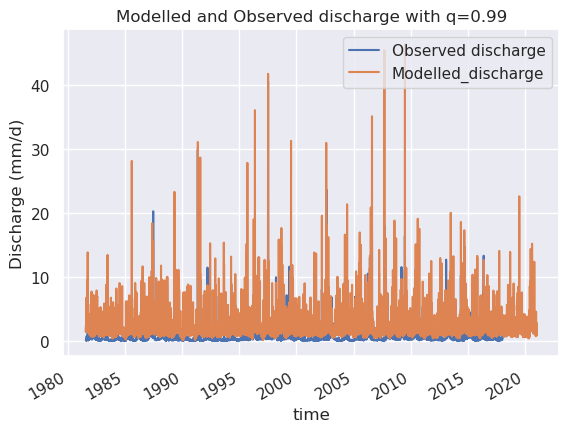

In [45]:
ds_forcing["Q"].plot(label="Observed discharge")
model_output99.plot()
plt.legend()
plt.ylabel("Discharge (mm/d)")
plt.title('Modelled and Observed discharge with q=0.99')

In [46]:
# par_97 = result97.x
# model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
# config_file, _ = model.setup(parameters=par_97, initial_storage=s_0)
# model.initialize(config_file)

In [47]:
# Q_m = []
# time = []
# while model.time < model.end_time:
#     model.update()
#     Q_m.append(model.get_value("Q")[0])
#     time.append(pd.Timestamp(model.time_as_datetime))
# model.finalize()

In [48]:
# model_output97 = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

In [49]:
# ds_forcing["Q"].plot(label="Observed discharge")
# model_output97.plot()
# plt.legend()
# plt.ylabel("Discharge (mm/d)")
# plt.title('Modelled and Observed discharge with q=0.99')

The next step is to validate the model output. This is done on the validation time period, which is the last 25 percent, so the last ten years, of the observed data. The mean absolute difference of the model output and the observed data, named the objective, of the calibration period can be compared to the objective of the validation period. The model is not overfitted for the calibration period, and thus usable for future predictions, if the objective values are similar. 

In [50]:
Q_pandas = ds_forcing["Q"].to_dataframe()
def objective_function_validation(parameter_vector, q):
    model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
    config_file, _ = model.setup(            parameters = parameter_vector,
                            initial_storage=s_0,
                            cfg_dir = "configFiles/hbv_ensembleMember_",
                               )
    model.initialize(config_file)


   # discharge_this_timestep = model.get_value("Q") 
    Q_m = []
    time = []
    while model.time < model.end_time:
        model.update()
        discharge_this_timestep = model.get_value("Q")
        Q_m.append(discharge_this_timestep[0])
        time.append(pd.Timestamp(model.time_as_datetime.date()))
   # model.finalize()
   # print(model.get_value("Q"))

    #calculate the objective function 
    discharge_dataframe = pd.DataFrame({'model output': Q_m}, index=pd.to_datetime(time))

    objective_this_model = calibrationObjective_quantile_loss(discharge_dataframe,Q_pandas["Q"],validation_start_time,validation_end_time, q)
    del Q_m, time, discharge_dataframe
   
    if np.isnan(objective_this_model):
        return np.inf
    
    return objective_this_model

In [51]:
val90_objective = objective_function_validation([5.58471586e-06, 3.13412625e+00, 2.37953048e+02, 5.73162134e+00,
 6.52902354e-01, 1.45007782e+00, 5.04868854e-01, 4.09678016e-02,
 1.08868030e+00], 0.90)
# print(objective90)
# print(val90_objective)

In [52]:
val95_objective = objective_function_validation([1.11445722e-08, 2.44479717e+00, 4.25370410e+01, 1.22686880e+00,
 2.09277774e+00, 1.04205225e+00, 7.27472601e-01, 3.49031666e-02,
 1.08389293e+00], 0.95)
# print(objective90)
# print(val95_objective)

In [53]:
val99_objective = objective_function_validation([1.04288193e-05, 7.77284772e+01, 2.32176569e+01, 6.60999969e-01,
 3.51075714e+00, 9.61766614e-01, 8.11764125e-01, 3.70046705e-02,
 1.00978819e+00], 0.99)
# print(objective99)
# print(val99_objective)

It can be seen that for all three models, the objective for the validation period is lower than the objective for the training period. This would mean that the model is not overfit on the trainingsdata, since it is able to make good predictions on unseen data. The fact that the objective is lower for the testdata could mean that the testdata contains data that is easier to predict. It can be seen in the graphs above, that the observed data in the test period, so from 2010 to 2021, does not contain peaks as high as in the training period, from 1980 to 2010. The model might be improved by using cross validation.

### Kling Gupta efficiency

For my research, the height and frequency of the peaks are important, but their timing is less critical. The Kling-Gupta Efficiency is a measure that evaluates how well a model performs by looking at correlation, bias, and variability. By using an altered Kling-Gupta Efficiency in which the correlation is being left out, the timing of the peaks is not being taken into account. This method is useful for predicting the size of peaks and the overall distribution, while being less focused on the exact timing of the peaks.

A good way to predict the best parameter combination is through Nelder-Mead optimization. This optimization method finds the minimum of a function. The result of the Nelder-Mead optimization is the best parameter combination the method found. The Nelder-Mead optimization is run using the Kling-Gupta efficiency.

In [54]:
# import numpy as np
# Q_pandas = ds_forcing["Q"].to_dataframe()
# def kling_gupta_efficiency(obs, sim, start_calibration, end_calibration):

#     #combine the two in one dataFrame
#     hydro_data = pd.concat([sim.reindex(obs.index, method = 'ffill'), obs], axis=1)

#     #only select the calibration period
#     hydro_data = hydro_data[hydro_data.index > pd.to_datetime(pd.Timestamp(start_calibration).date())]
#     hydro_data = hydro_data[hydro_data.index < pd.to_datetime(pd.Timestamp(end_calibration).date())]


#     #  #calculate mean absolute difference to the power 4, so peaks weigh more
#     # diff = (hydro_data['Q'] - hydro_data['model output']) 
#     # absDiff = np.abs(diff)
#     # meanAbsDiff = np.mean(absDiff)
    
#     r = np.corrcoef(hydro_data['Q'], hydro_data['model output'])[0, 1]  # Correlation
#     beta = np.mean(hydro_data['model output']) / np.mean(hydro_data['Q'])  # Bias ratio
#     gamma = np.std(hydro_data['model output']) / np.std(hydro_data['Q'])  # Variability ratio
    
#     return -(1 - np.sqrt((r - 1) ** 2 + (beta - 1) ** 2 + (gamma - 1) ** 2))

# # objective = kling_gupta_efficiency(observations, model_output)


In [55]:
import numpy as np
Q_pandas = ds_forcing["Q"].to_dataframe()
def kling_gupta_efficiency(obs, sim, start_calibration, end_calibration):

    #combine the two in one dataFrame
    hydro_data = pd.concat([sim.reindex(obs.index, method = 'ffill'), obs], axis=1)

    #only select the calibration period
    hydro_data = hydro_data[hydro_data.index > pd.to_datetime(pd.Timestamp(start_calibration).date())]
    hydro_data = hydro_data[hydro_data.index < pd.to_datetime(pd.Timestamp(end_calibration).date())]


    #  #calculate mean absolute difference to the power 4, so peaks weigh more
    # diff = (hydro_data['Q'] - hydro_data['model output']) 
    # absDiff = np.abs(diff)
    # meanAbsDiff = np.mean(absDiff)
    
    r = np.corrcoef(hydro_data['Q'], hydro_data['model output'])[0, 1]  # Correlation
    beta = np.mean(hydro_data['model output']) / np.mean(hydro_data['Q'])  # Bias ratio
    gamma = np.std(hydro_data['model output']) / np.std(hydro_data['Q'])  # Variability ratio

    mean_pieken_output = hydro_data[hydro_data['model output'] > hydro_data['model output'].quantile(0.95)]["model output"].mean()
    mean_pieken_obs = hydro_data[hydro_data['Q'] > hydro_data['Q'].quantile(0.95)]["Q"].mean()
    ratio_pieken = mean_pieken_output / mean_pieken_obs


    #aangepaste kling-gupta zonder correlatie: geen tijds afhankelijke component
    return -(1 - np.sqrt((beta - 1) ** 2 + (gamma - 1) ** 2))
    
    # return -(1 - np.sqrt((r - 1) ** 2 + (beta - 1) ** 2 + (gamma - 1) ** 2 + (ratio_pieken - 1)**2))

# objective = kling_gupta_efficiency(observations, model_output)


In [56]:
def objective_function(parameter_vector):
    model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
    config_file, _ = model.setup(            parameters = parameter_vector,
                            initial_storage=s_0,
                            cfg_dir = "configFiles/hbv_ensembleMember_",
                               )
    model.initialize(config_file)


   # discharge_this_timestep = model.get_value("Q") 
    Q_m = []
    time = []
    while model.time < model.end_time:
        model.update()
        discharge_this_timestep = model.get_value("Q")
        Q_m.append(discharge_this_timestep[0])
        time.append(pd.Timestamp(model.time_as_datetime.date()))
   # model.finalize()
   # print(model.get_value("Q"))

    #calculate the objective function 
    discharge_dataframe = pd.DataFrame({'model output': Q_m}, index=pd.to_datetime(time))

    objective_this_model = kling_gupta_efficiency(discharge_dataframe, Q_pandas["Q"], calibration_start_time, calibration_end_time)
    del Q_m, time, discharge_dataframe
   
    if np.isnan(objective_this_model):
        return np.inf
    
    return objective_this_model

In [57]:
# from scipy.optimize import minimize


# #bounds = [(0, 500), (0.2, 10),(40, 10000),(0.5, 10000),(0.001, 300),(1, 100),(0.01, 100),(0.0001, 10),(0.01, 100)]
# bounds = [(0, None), (0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None)]

# result90 = minimize(objective_function, [2.52268517e-05, 2.20175052e+00, 1.45074493e+02, 2.48038674e+00,
#        1.01841470e+00, 6.84361550e-01, 5.85949449e-01, 4.42305303e-02,
#        1.05644244e+00], bounds=bounds, method='Nelder-Mead', options={'maxiter':3000})

In [58]:
# result90

In [59]:
# result90.x
# result90 = [7.34828691e-05, 2.27980671e+00, 3.97078692e+02, 4.84468361e+00,
#        6.23856365e-03, 8.49211209e-01, 5.44326491e-01, 8.85417304e-03,
#        1.00205456e+00]

# no correlation:
result90 = [3.45931194e-05, 1.14214815e+00, 8.18372400e+01, 3.33622498e+00,
       7.92467684e-01, 7.14312426e-01, 6.98977188e-01, 4.48466788e-02,
       1.08758732e+00]

In [60]:
# result90.fun
# objective = -0.5152300312227525
# no correlation:
# objective = -0.9999994796207085

In [61]:
par = result90
model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
config_file, _ = model.setup(parameters=par, initial_storage=s_0)
model.initialize(config_file)

In [62]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))
model.finalize()

In [63]:
model_output = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

Text(0, 0.5, 'Discharge (mm/d)')

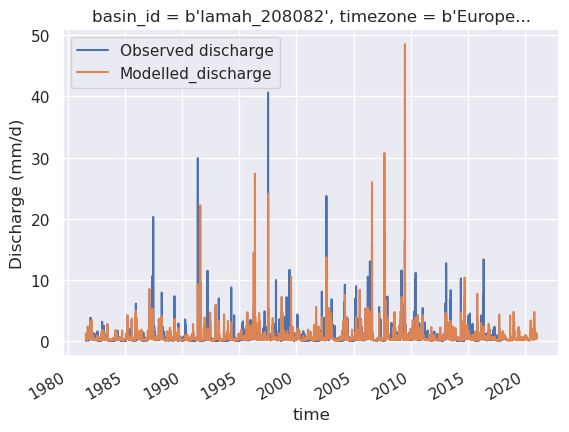

In [64]:
ds_forcing["Q"].plot(label="Observed discharge")
model_output.plot()
plt.legend()
plt.ylabel("Discharge (mm/d)")

To be able to compare the model output to the observation data, the model output is converted from mm/day to m3/s as well. This is plotted below.

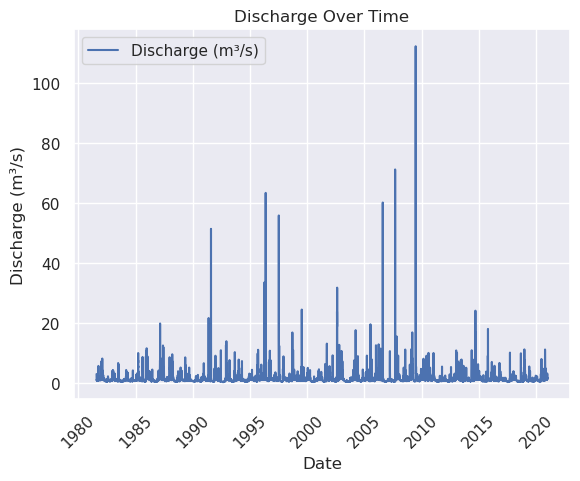

In [65]:
catchment_area = ds_forcing["area"].values

df = pd.DataFrame(model_output)
model_data = df['Modelled_discharge'] * catchment_area * 1000 / (24 * 60 * 60)

plt.plot(df.index, model_data, label='Discharge (m³/s)')

plt.xlabel('Date')
plt.ylabel('Discharge (m³/s)')
plt.title('Discharge Over Time')
plt.xticks(rotation=45)  # Draai de datums voor betere leesbaarheid
plt.legend()

plt.savefig("/home/thirza/BEPproject/book/Grafieken/modelleddischarge.png", dpi=300)
plt.show()



To be able to evaluate the performence of the model, the extrapolated returnperiods for the modeloutput need to be compared to the extrapolated returnperiods for the observations. The modelled daily discharges are plotted below. The returnperiods still have to be extrapolated.

De bijbehorende x-waarde voor y = 530 is: 554.60

Text(0, 0.5, 'Discharge (m3/s)')

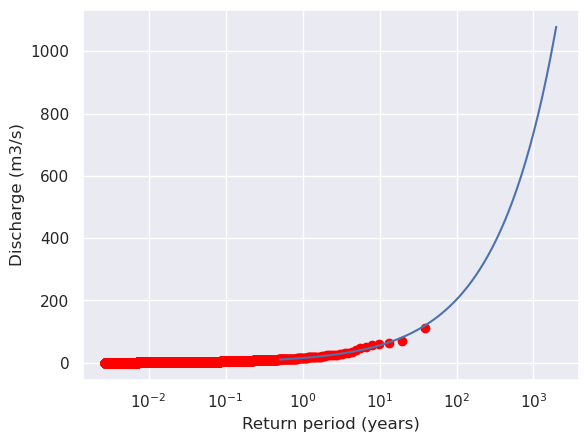

In [66]:
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

# Sort data from high to low
sorted_model_data = np.sort(model_data)[::-1]  # Sorteer aflopend

#calculate return periods
m = len(sorted_model_data)
rank = np.arange(1, m + 1)
return_periods_days_model = (m + 1) / rank
return_periods_years_model = return_periods_days_model / 365


# 0.5 because we want to extrapolate the peaks, so look at discharges that occure more than 2 times a year
return_periods_years_model_subset = return_periods_years_model[return_periods_years_model >= 0.5]
sorted_model_data_subset = sorted_model_data[return_periods_years_model >= 0.5]

log_x = np.log(return_periods_years_model_subset)
log_y = np.log(sorted_model_data_subset)  # Log-transformeer y

def linear_model(log_x, a, b):
    return a * log_x + b


# Lineaire fit in log-log ruimte
params, _ = curve_fit(linear_model, log_x, log_y)
a, b = params

# Exponentiële fitlijn (terugtransformatie)
x_fit = np.logspace(np.log10(min(return_periods_years_model_subset)), np.log10(max(return_periods_years_model_subset)*50), 200)
y_fit = np.exp(linear_model(np.log(x_fit), a, b))  # Terug naar gewone schaal

# Gegeven y-waarde
y_value = 530

# Bereken de bijbehorende x-waarde
log_y_value = np.log(y_value)  # Neem de log van y
log_x_value = (log_y_value - b) / a  # Los op voor log(x)
x_value = np.exp(log_x_value)  # Terug naar gewone schaal

# Print de bijbehorende x-waarde
print(f"De bijbehorende x-waarde voor y = {y_value} is: {x_value:.2f}")

plt.xscale('log')
plt.scatter(return_periods_years_model, sorted_model_data, color="red", label="Waarden")
plt.plot(x_fit, y_fit)
plt.xlabel('Return period (years)')
plt.ylabel('Discharge (m3/s)')
# plt.grid(True, which="both", linestyle="--", linewidth=0.5)

To be able to compare the model output to the observation data, the model output is converted from mm/day to m3/s as well. This is plotted below.

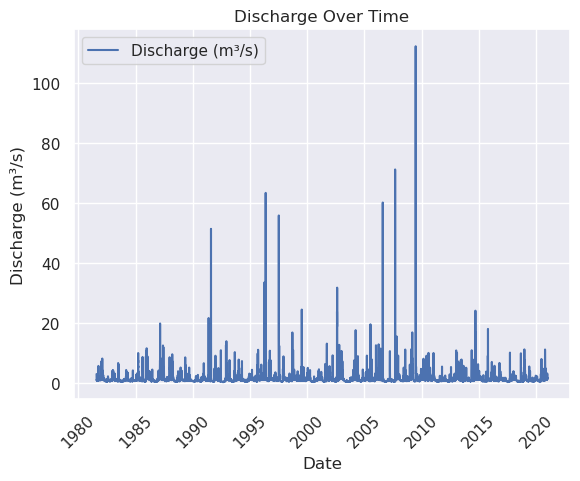

In [67]:
catchment_area = ds_forcing["area"].values

df = pd.DataFrame(model_output)
model_data = df['Modelled_discharge'] * catchment_area * 1000 / (24 * 60 * 60)

plt.plot(df.index, model_data, label='Discharge (m³/s)')

plt.xlabel('Date')
plt.ylabel('Discharge (m³/s)')
plt.title('Discharge Over Time')
plt.xticks(rotation=45)  # Draai de datums voor betere leesbaarheid
plt.legend()
plt.show()

To be able to evaluate the performence of the model, the extrapolated returnperiods for the modeloutput need to be compared to the extrapolated returnperiods for the observations. The modelled daily discharges are plotted below. The returnperiods still have to be extrapolated.

## Wasserstein & Nelder Mead

In [68]:
def calibrationObjective_wasserstein(modelOutput, observation, start_calibration, end_calibration):
    # a function that takes in two dataFrames, interpolates the model output to the
    # observations and calculates the average absolute difference between the two.

    #combine the two in one dataFrame
    hydro_data = pd.concat([modelOutput.reindex(observation.index, method = 'ffill'), observation], axis=1)

    #only select the calibration period
    hydro_data = hydro_data[hydro_data.index > pd.to_datetime(pd.Timestamp(start_calibration).date())]
    hydro_data = hydro_data[hydro_data.index < pd.to_datetime(pd.Timestamp(end_calibration).date())]

    #calculate mean absolute difference to the power 4, so peaks weigh more
    
    # diff = (hydro_data['Q'].sort_values() - hydro_data['Modelled_discharge'].sort_values()) ** 2
    # absDiff = np.abs(diff)
    # meanAbsDiff = np.mean(absDiff)
    # return meanAbsDiff

    return wasserstein_distance(hydro_data['Q'], hydro_data['Modelled_discharge'])

In [13]:
Q_pandas = ds_forcing["Q"].to_dataframe()

def objective_function_wasserstein(parameter_vector):
    model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
    config_file, _ = model.setup(            parameters = parameter_vector,
                            initial_storage=s_0,
                            cfg_dir = "configFiles/hbv_ensembleMember_",
                               )
    model.initialize(config_file)


   # discharge_this_timestep = model.get_value("Q") 
    Q_m = []
    time = []
    while model.time < model.end_time:
        model.update()
        discharge_this_timestep = model.get_value("Q")
        Q_m.append(discharge_this_timestep[0])
        time.append(pd.Timestamp(model.time_as_datetime.date()))
   # model.finalize()
   # print(model.get_value("Q"))

    #calculate the objective function 
    discharge_dataframe = pd.DataFrame({'Modelled_discharge': Q_m}, index=pd.to_datetime(time))
    objective_this_model = calibrationObjective_wasserstein(discharge_dataframe,Q_pandas["Q"],calibration_start_time,calibration_end_time)
    del Q_m, time, discharge_dataframe
   
    if np.isnan(objective_this_model):
        return np.inf
    
    return objective_this_model

In [70]:
from scipy.stats import wasserstein_distance

In [71]:
# bounds = [(0, None), (0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None)]

# result = minimize(objective_function_wasserstein, [2.52268517e-05, 2.20175052e+00, 1.45074493e+02, 2.48038674e+00,
#        1.01841470e+00, 6.84361550e-01, 5.85949449e-01, 4.42305303e-02,
#        1.05644244e+00], bounds=bounds, method='Nelder-Mead', options={'maxiter':3000})

In [72]:
# result

In [73]:
# result.x
# 90/10
# # result = [6.51669781e-05, 6.38655600e-01, 5.30024294e+01, 1.56641841e+00,
# #        1.10734080e+00, 1.49999999e+00, 5.50209588e-01, 3.74966606e-02,
# #        1.04773070e+00]

# 70/30
result = [5.15724216e-05, 8.36587345e-01, 3.90778393e+01, 3.57466531e+00,
       1.06383450e+00, 9.37562028e-01, 3.02412699e-01, 8.15566365e-02,
       2.90551458e+00]

In [74]:
# result.fun
# 90/10
# # objective = 0.027397519552779696

# 70/30
# objective = 0.01965939310646257

In [75]:
par = result
model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
config_file, _ = model.setup(parameters=par, initial_storage=s_0)
model.initialize(config_file)

In [76]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))
model.finalize()

In [77]:
model_output = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

Text(0, 0.5, 'Discharge (mm/d)')

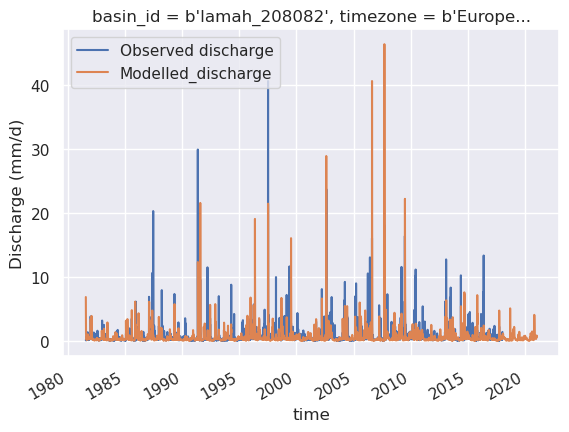

In [78]:
ds_forcing["Q"].plot(label="Observed discharge")
model_output.plot()
plt.legend()
plt.ylabel("Discharge (mm/d)")

In [79]:
calibration_start_time = pd.to_datetime(calibration_start_time)
calibration_end_time = pd.to_datetime(calibration_end_time)

df.index = df.index.tz_localize(None)  # Remove timezone
Q_pandas.index = Q_pandas.index.tz_localize(None)
calibration_start_time = calibration_start_time.tz_localize(None)
calibration_end_time = calibration_end_time.tz_localize(None)

model_output_filtered = model_output.loc[calibration_start_time:calibration_end_time]
ds_forcing_filtered = ds_forcing["Q"].loc[calibration_start_time:calibration_end_time]

Text(0, 0.5, 'Discharge (mm/d)')

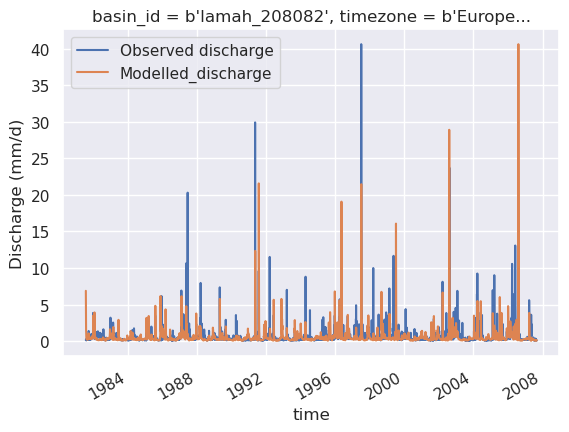

In [80]:
ds_forcing_filtered.plot(label="Observed discharge")
model_output_filtered.plot()
plt.legend()
plt.ylabel("Discharge (mm/d)")

Text(0, 0.5, 'Discharge (mm/day)')

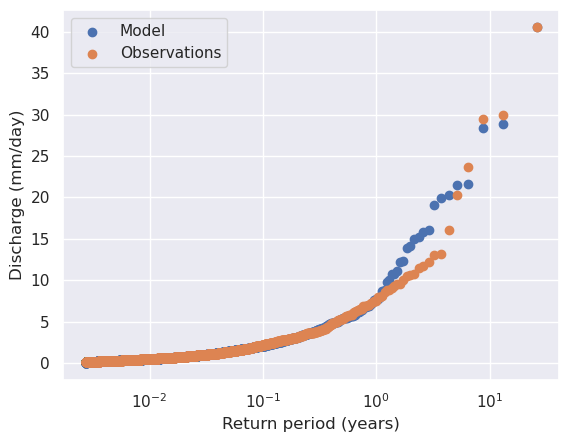

In [81]:
# Sort data from high to low
sorted_model_data = np.sort(model_output_filtered)[::-1]  # Sorteer aflopend
ds_forcing_filtered = np.sort(ds_forcing_filtered)[::-1]

#calculate return periods
m = len(sorted_model_data)
rank = np.arange(1, m + 1)
return_periods_days_model = (m + 1) / rank
return_periods_years_model = return_periods_days_model / 365.25


m = len(ds_forcing_filtered)
rank = np.arange(1, m + 1)
return_periods_days_obs = (m + 1) / rank
return_periods_years_obs = return_periods_days_obs / 365.25

plt.xscale('log')
plt.scatter(return_periods_years_model, sorted_model_data, label='Model')
plt.scatter(return_periods_years_obs, ds_forcing_filtered, label='Observations')
plt.legend()
plt.xlabel('Return period (years)')
plt.ylabel('Discharge (mm/day)')

In [82]:
validation_start_time = pd.to_datetime(validation_start_time)
validation_end_time = pd.to_datetime(validation_end_time)

df.index = df.index.tz_localize(None)  # Remove timezone
Q_pandas.index = Q_pandas.index.tz_localize(None)
validation_start_time = validation_start_time.tz_localize(None)
validation_end_time = validation_end_time.tz_localize(None)
# Filter de modeloutput voor de geselecteerde periode
model_output_filtered = model_output.loc[validation_start_time:validation_end_time]

# Als je ook de waargenomen afvoer wilt filteren, doe je hetzelfde:
ds_forcing_filtered = ds_forcing["Q"].loc[validation_start_time:validation_end_time]

Text(0, 0.5, 'Discharge (mm/d)')

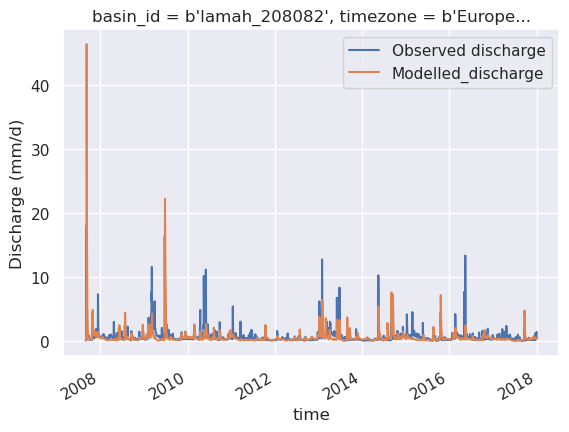

In [83]:
ds_forcing_filtered.plot(label="Observed discharge")
model_output_filtered.plot()
plt.legend()
plt.ylabel("Discharge (mm/d)")

Text(0, 0.5, 'Discharge (mm/day)')

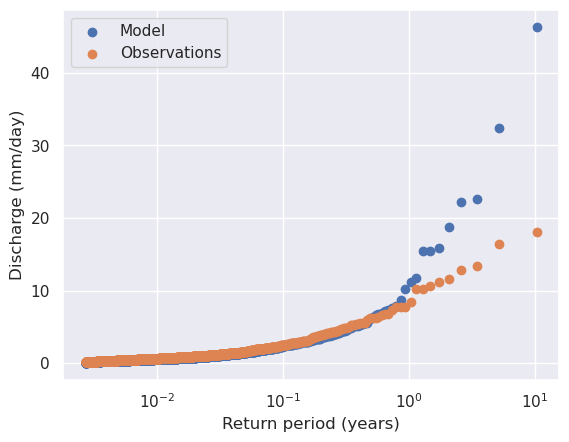

In [84]:
# Sort data from high to low
sorted_model_data = np.sort(model_output_filtered)[::-1]  # Sorteer aflopend
ds_forcing_filtered = np.sort(ds_forcing_filtered)[::-1]

#calculate return periods
m = len(sorted_model_data)
rank = np.arange(1, m + 1)
return_periods_days_model = (m + 1) / rank
return_periods_years_model = return_periods_days_model / 365.25


m = len(ds_forcing_filtered)
rank = np.arange(1, m + 1)
return_periods_days_obs = (m + 1) / rank
return_periods_years_obs = return_periods_days_obs / 365.25

plt.xscale('log')
plt.scatter(return_periods_years_model, sorted_model_data, label='Model')
plt.scatter(return_periods_years_obs, ds_forcing_filtered, label='Observations')
plt.legend()
plt.xlabel('Return period (years)')
plt.ylabel('Discharge (mm/day)')

To be able to compare the model output to the observation data, the model output is converted from mm/day to m3/s as well. This is plotted below.

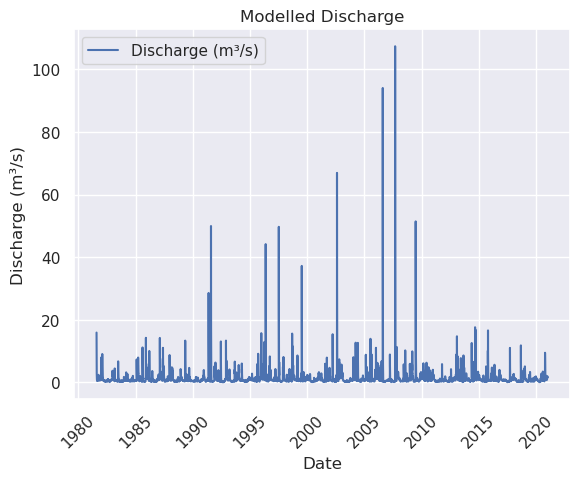

In [85]:
catchment_area = ds_forcing["area"].values

df = pd.DataFrame(model_output)
model_data = df['Modelled_discharge'] * catchment_area * 1000 / (24 * 60 * 60)

plt.plot(df.index, model_data, label='Discharge (m³/s)')

plt.xlabel('Date')
plt.ylabel('Discharge (m³/s)')
plt.title('Modelled Discharge')
plt.xticks(rotation=45)  # Draai de datums voor betere leesbaarheid
plt.legend()

plt.savefig("/home/thirza/BEPproject/book/Grafieken/modelleddischarge.png", dpi=300)
plt.show()

Voor y = 530, de overeenkomstige x-waarde is 3602.1284711395297

For y = 530, the x_value is 2105.4066266379127

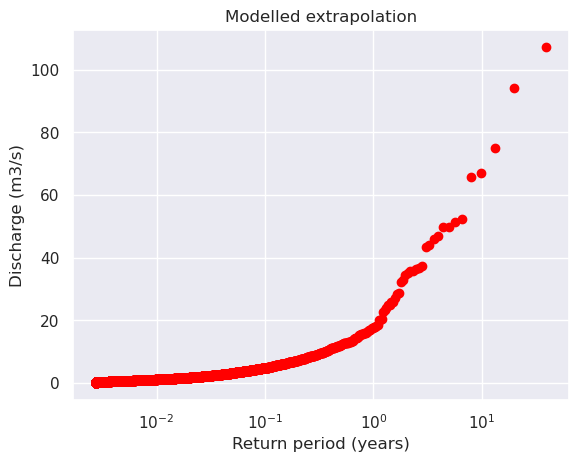

In [86]:
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

# Sort data from high to low
sorted_model_data = np.sort(model_data)[::-1]  # Sorteer aflopend

#calculate return periods
m = len(sorted_model_data)
rank = np.arange(1, m + 1)
return_periods_days_model = (m + 1) / rank
return_periods_years_model = return_periods_days_model / 365


# 0.5 because we want to extrapolate the peaks, so look at discharges that occure 2 times a year or more
return_periods_years_model_subset = return_periods_years_model[return_periods_years_model >= 2]
sorted_model_data_subset = sorted_model_data[return_periods_years_model >= 2]

# log_x = np.log(return_periods_years_model_subset)
# log_y = np.log(sorted_model_data_subset)  # Log-transformeer y

# def linear_model(log_x, a, b):
#     return a * log_x + b


# # Lineaire fit in log-log ruimte
# params, _ = curve_fit(linear_model, log_x, log_y)
# a, b = params

# # Exponentiële fitlijn (terugtransformatie)
# x_fit = np.logspace(np.log10(min(return_periods_years_model_subset)), np.log10(max(return_periods_years_model_subset)*50), 200)
# y_fit = np.exp(linear_model(np.log(x_fit), a, b))  # Terug naar gewone schaal

# # Gegeven y-waarde
# y_value = 530

# # Bereken de bijbehorende x-waarde
# log_y_value = np.log(y_value)  # Neem de log van y
# log_x_value = (log_y_value - b) / a  # Los op voor log(x)
# x_value = np.exp(log_x_value)  # Terug naar gewone schaal

# # Print de bijbehorende x-waarde
# print(f"De bijbehorende x-waarde voor y = {y_value} is: {x_value:.2f}")



# Definieer een functie voor het fitten (bijv. polynoom van graad 7)
# def fit_function(x, a, b, c, d, e, f, g):
#     return (a * np.log10(x)**6 + b * np.log10(x)**5 + c * np.log10(x)**4 + 
#             d * np.log10(x)**3 + e * np.log10(x)**2 + f * np.log10(x) + 
#             g)

def fit_function(x, a, b, c, d, e):
    return (a * np.log10(x)**4 + b * np.log10(x)**3 + c * np.log10(x)**2 + 
            d * np.log10(x) + e)

# Voer curve fitting uit
params, params_covariance = curve_fit(fit_function, return_periods_years_model, sorted_model_data)

# Genereer gefitte lijn met uitgebreid bereik
x_extended = np.logspace(-2, 5, num=100)  # Breid x-bereik uit van 10^-2 tot 10^5
line_extended = fit_function(x_extended, params[0], params[1], params[2], params[3],
                             params[4])


# plt.plot(x_extended, line_extended, color='blue', label='Fitted line')


# Functie om x te vinden voor een gegeven y-waarde
def find_x_for_y(y_value):
    # Definieer de vergelijking om op te lossen
    def equation_to_solve(x):
        return fit_function(x, params[0], params[1], params[2], params[3], params[4]) - y_value
    
    # Gebruik een root-finding algoritme om de x-waarde te vinden
    x_solution = fsolve(equation_to_solve, x0=1)  # Initiële gok x0=1
    return x_solution[0]

# Voorbeeld: Vind x voor een gegeven y-waarde
y_value = 530
x_value = find_x_for_y(y_value)
print(f"Voor y = {y_value}, de overeenkomstige x-waarde is {x_value}")




def power_law(x, a, b):
    return a * x ** b

# weights = 1 / return_periods_years_model

params, _ = curve_fit(power_law, return_periods_years_model_subset, sorted_model_data_subset, maxfev=10000)

a_opt, b_opt = params
# b_opt *= 0.92

x_fit = np.logspace(np.log(min(return_periods_years_model_subset)/20), np.log(max(return_periods_years_model_subset)), 1000)
y_fit = power_law(x_fit, a_opt, b_opt)

def find_x_for_y(y_target, a, b):
    return (y_target / a) ** (1 / b)

y_target = 530
x_value = find_x_for_y(y_target, a_opt, b_opt)
print(f"For y = {y_target}, the x_value is {x_value}")

plt.xscale('log')
plt.scatter(return_periods_years_model, sorted_model_data, color="red", label="Waarden")
# plt.plot(x_fit, y_fit)
plt.xlabel('Return period (years)')
plt.ylabel('Discharge (m3/s)')

# plt.hlines(y_target, xmin=min(return_periods_years_model), xmax=x_value, colors='g', linestyles='dashed', label="y=530 Line")
# plt.vlines(x_value, ymin=0, ymax=y_target, colors='g', linestyles='dashed', label="Intersection to x-axis")
# plt.text(x_value, -50, f'{x_value:.0f} years', ha='center', fontsize=12, color='black')  # X-label net onder de as
# plt.text(min(return_periods_years_model) / 2, y_target, f'{y_target:.0f} $m^3/s$', va='center', fontsize=12, color='black')  # Y-label links naast lijn


plt.title('Modelled extrapolation')
# plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.savefig("/home/thirza/BEPproject/book/Grafieken/Scatter.png", dpi=300)

In [87]:
df['Modelled_discharge'].dropna(inplace=True)
Q_pandas["Q"].dropna(inplace=True)

validation_start_time = pd.to_datetime(validation_start_time)
validation_end_time = pd.to_datetime(validation_end_time)

df.index = df.index.tz_localize(None)  # Remove timezone
Q_pandas.index = Q_pandas.index.tz_localize(None)
validation_start_time = validation_start_time.tz_localize(None)
validation_end_time = validation_end_time.tz_localize(None)

df_filtered = df[(df.index >= validation_start_time) & (df.index <= validation_end_time)]
Q_filtered = Q_pandas[(Q_pandas.index >= validation_start_time) & (Q_pandas.index <= validation_end_time)]

print(f'The objective for the validation period is {calibrationObjective_wasserstein(df['Modelled_discharge'], Q_pandas["Q"], validation_start_time, validation_end_time)}')

The objective for the validation period is 0.10358256978779298

In [88]:
print(f'The objective for the calibration period is {calibrationObjective_wasserstein(df['Modelled_discharge'], Q_pandas["Q"], calibration_start_time, calibration_end_time)}')

The objective for the calibration period is 0.019659393123037744

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit

def expanding_window_cross_validation(model, forcing_data, observation_data, calibration_start_time, calibration_end_time, n_splits=5):
    # Zet de data om naar een pandas DataFrame en stel de tijdstempel in
    observation_data.index = pd.to_datetime(observation_data.index)
    forcing_data.index = pd.to_datetime(forcing_data.index)
    
    # Zet de tijdsbereiken voor training en testen
    calibration_start_time = pd.to_datetime(calibration_start_time)
    calibration_end_time = pd.to_datetime(calibration_end_time)

    # Tijdstempels voor de splits
    time_index = pd.date_range(calibration_start_time, calibration_end_time, freq='D')
    n_total_points = len(time_index)

    # Splitsing in tijd (expandend window)
    split_size = n_total_points // n_splits
    results = []

    # Loop door de verschillende splits
    for i in range(n_splits):
        # Bepaal de trainingstijdsspanne
        training_end_time = calibration_start_time + pd.Timedelta(days=(split_size * (i + 1)))

        # Maak de training- en testsets
        train_data = forcing_data.loc[calibration_start_time:training_end_time]
        test_data = forcing_data.loc[training_end_time:calibration_end_time]

        obs_train_data = observation_data.loc[calibration_start_time:training_end_time]
        obs_test_data = observation_data.loc[training_end_time:calibration_end_time]

        # Voer de modeloptimalisatie uit voor dit window
        result = optimize_model_with_window(model, train_data, obs_train_data, test_data, obs_test_data)
        results.append(result)

    # Gemiddelde prestaties
    return np.mean(results), np.std(results)

def optimize_model_with_window(model, train_data, obs_train_data, test_data, obs_test_data):
    # Zet het model op met de train_data
    # Hier zou je de modelinstantie kunnen initialiseren en optimaliseren, net als in de originele code
    parameter_vector = [2.52268517e-05, 2.20175052e+00, 1.45074493e+02, 2.48038674e+00,
                        1.01841470e+00, 6.84361550e-01, 5.85949449e-01, 4.42305303e-02,
                        1.05644244e+00]
    
    # Gebruik je optimale parameters om het model te initialiseren
    model = ewatercycle.models.HBVLocal(forcing=train_data)
    config_file, _ = model.setup(parameters=parameter_vector, initial_storage=0, cfg_dir="configFiles/hbv_ensembleMember_")
    model.initialize(config_file)
    
    Q_m = []
    time = []
    while model.time < model.end_time:
        model.update()
        discharge_this_timestep = model.get_value("Q")
        Q_m.append(discharge_this_timestep[0])
        time.append(pd.Timestamp(model.time_as_datetime.date()))

    discharge_series = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

    # Bereken de objective function met de testdata
    objective_value = objective_function_sorted_maximum(discharge_series, obs_test_data, test_data.index[0], test_data.index[-1])

    # Return de performance van dit model op de testset
    return objective_value


In [40]:
# Definieer het model (zoals in je originele code)
model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)

# Controleer of observation_data een pandas Series is
print(type(Q_pandas["Q"]))  # Dit moet <class 'pandas.core.series.Series'> zijn
# Controleer de tijdindex van observation_data
# Zorg ervoor dat de tijdindex in datetime-formaat is (indien nodig)
Q_pandas["Q"].index = pd.to_datetime(Q_pandas["Q"].index)

print(Q_pandas["Q"].index)
# Controleer de kolommen van ds_forcing




# Voer de expanding window cross-validation uit
mean_error, std_error = expanding_window_cross_validation(
    model=model,
    forcing_data=ds_forcing["Q"].to_pandas(),
    observation_data=Q_pandas["Q"],
    calibration_start_time="2021-01-01",  # Bijvoorbeeld
    calibration_end_time="2021-12-31",    # Bijvoorbeeld
    n_splits=5
)

# print(f"Gemiddelde fout: {mean_error}")
# print(f"Standaarddeviatie van de fout: {std_error}")


<class 'pandas.core.series.Series'>

DatetimeIndex(['1981-08-01', '1981-08-02', '1981-08-03', '1981-08-04',
               '1981-08-05', '1981-08-06', '1981-08-07', '1981-08-08',
               '1981-08-09', '1981-08-10',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='time', length=14398, freq=None)

ValidationError: 1 validation error for HBVLocal
forcing
  Input should be a valid dictionary or instance of DefaultForcing [type=model_type, input_value=Series([], Name: Q, dtype: float32), input_type=Series]
    For further information visit https://errors.pydantic.dev/2.10/v/model_type

In [51]:
import pandas as pd
import xarray as xr
from ewatercycle.models import HBVLocal
# from ewatercycle import Forcing
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# # Laad de data (vervang dit met je daadwerkelijke dataset)
# ds_forcing = xr.open_dataset('path/to/your/data.nc')

# Zet de 'Q' variabele om naar een pandas Series
observation_data = ds_forcing['Q'].to_pandas()
observation_data.index = pd.to_datetime(observation_data.index)

# Maak het Forcing object met de juiste variabelen
forcing_data = ewatercycle.forcing(
    precip=ds_forcing['pr'],  # Neerslag (vervang dit met de juiste naam van de variabele)
    potev=ds_forcing['evspsblpot'],      # Temperatuur (vervang dit met de juiste naam van de variabele)
    q=ds_forcing['Q'],            # Afvoer (vervang dit met de juiste naam van de variabele)
)

# Definieer het model
model = HBVLocal(forcing=forcing_data)

# Definieer de TimeSeriesSplit (bijvoorbeeld 5 splits)
tscv = TimeSeriesSplit(n_splits=5)

# Resultaten opslaan
mean_errors = []
std_errors = []

# Loop door de splits van de TimeSeriesSplit
for train_index, test_index in tscv.split(observation_data):
    # Maak de train- en testsets
    train_data = observation_data.iloc[train_index]
    test_data = observation_data.iloc[test_index]
    
    # Maak het Forcing object voor de trainset
    train_forcing_data = forcing(
        precip=ds_forcing['pr'].isel(time=train_index),
        temp=ds_forcing['evspsblpot'].isel(time=train_index),
        q=ds_forcing['Q'].isel(time=train_index),
    )
    
    # Initialiseer het model
    model = HBVLocal(forcing=train_forcing_data)
    
    # Train het model (dit zou een daadwerkelijke trainingsstap zijn, afhankelijk van je model)
    model.initialize()  # Je moet dit eventueel aanpassen aan hoe het model werkt

    # Maak voorspellingen voor de testset
    predictions = model.get_value("Q")  # Zorg ervoor dat dit de voorspellingen zijn

    # Bereken de fout tussen voorspellingen en echte observaties
    error = np.sqrt(np.mean((predictions - test_data) ** 2))  # RMSE als foutmaat
    mean_errors.append(np.mean(error))
    std_errors.append(np.std(error))

# Gemiddelde en standaarddeviatie van de fout
mean_error = np.mean(mean_errors)
std_error = np.mean(std_errors)

# Resultaten printen
print(f"Gemiddelde fout: {mean_error}")
print(f"Standaarddeviatie van de fout: {std_error}")


TypeError: 'module' object is not callable